In [5]:
pip install plot_policy


ERROR: Could not find a version that satisfies the requirement plot_policy (from versions: none)
ERROR: No matching distribution found for plot_policy


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 500000/500000.

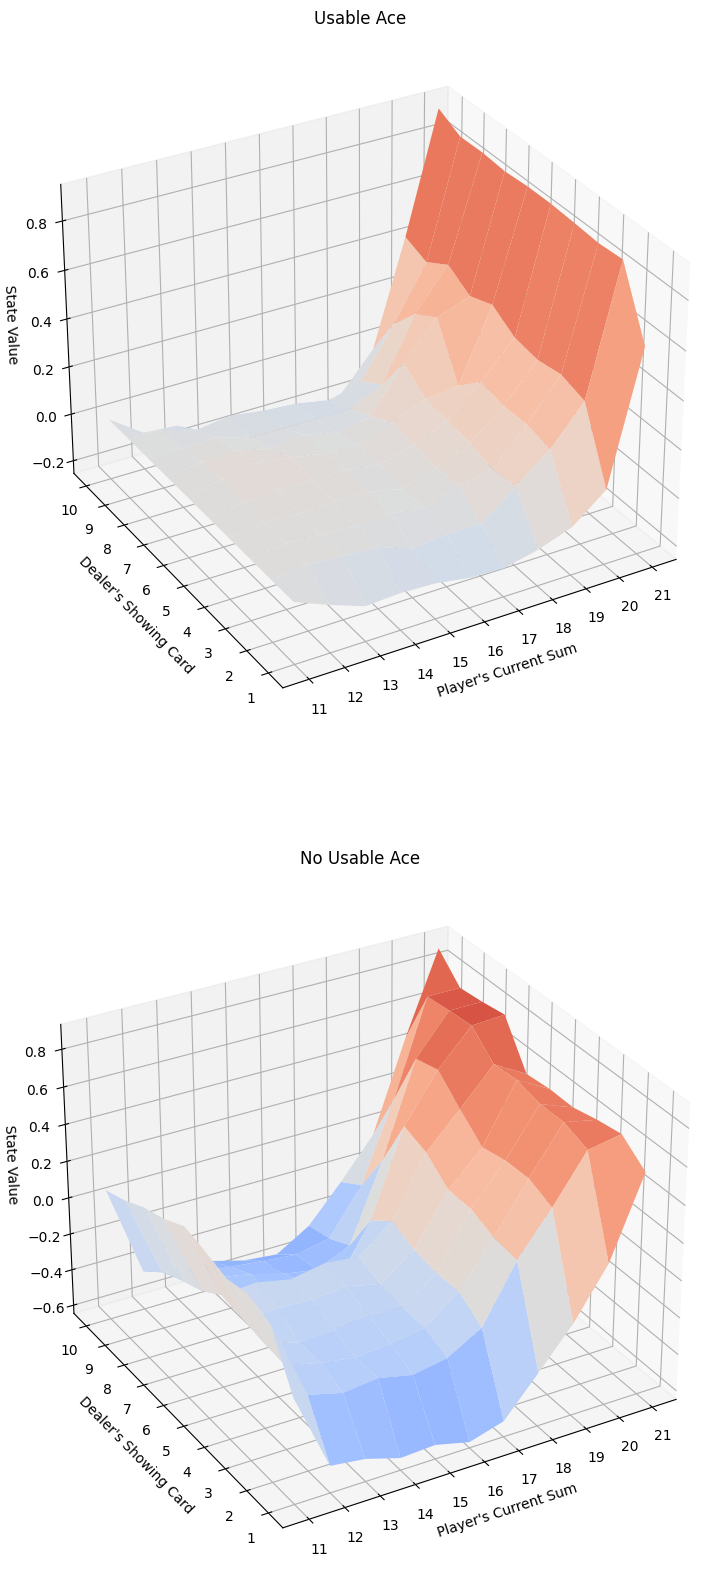

In [9]:
import sys
import random
import gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

def plot_blackjack_values(V):
    """
    Plots the value function `V` for a given blackjack environment.
    """
    def get_Z(x, y, usable_ace):
        if (x, y, usable_ace) in V:
            return V[x, y, usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x, y, usable_ace) for x in x_range] for y in y_range])
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_yticks(range(1, 11))
        ax.set_xticks(range(11, 22))
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def get_probs(Q_s, epsilon, nA):
    """
    Get the probability of taking the best known action according to epsilon.
    Returns the policy for the Q value given
    """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def best_policy(Q,nA):
    """
    returns the best actions for each Q value in the policy
    """
    return dict((k,np.argmax(v)) for k, v in Q.items())

def update_Q(env, episode, Q, alpha, gamma):
    """
    Calculate the new Q values for the actions taken in the given episode.
    Returns the new Q policy
    """

    for s, a, r in episode:
        first_occurrence_idx = next(i for i,x in enumerate(episode) if x[0] == s)
        G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurrence_idx:])])
        Q[s][a] = Q[s][a] + alpha*(G - Q[s][a])

    return Q

def play_game(env, Q, epsilon, nA):
    """
    generates an episode from following the epsilon-greedy policy containing the state, action and reward for
    each time step in the episode.
    Returns all step information for that episode
    """
    episode = []
    state = env.reset()
    while True:
        probs = get_probs(Q[state], epsilon, nA)
        action = np.random.choice(np.arange(nA), p=probs) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def mc_control(env, num_episodes):
    """
    main method. Iterates through episodes updating epsilon after each, retrieves the list of states, actions
    and rewards from the last episode and use them to calculate the updated Q values
    """
    epsilon = 1.0
    eps_min = 0.01
    decay = 0.9999
    alpha = 0.001
    gamma = 1.0

    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        epsilon = max(epsilon*decay, eps_min)
        episode = play_game(env, Q, epsilon, nA)
        Q = update_Q(env, episode, Q, alpha, gamma)

    policy = best_policy(Q, nA)
    return policy, Q

env = gym.make('Blackjack-v1')  # Use 'Blackjack-v1' instead of 'Blackjack-v0'
policy, Q = mc_control(env, 500000)
V = dict((k,np.max(v)) for k, v in Q.items())

plot_blackjack_values(V)
